In [1]:
!pip install aif360

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.7/259.7 kB 3.7 MB/s eta 0:00:00


In [2]:
!pip install holisticai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.6/362.6 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.0/241.0 kB 14.6 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

from holisticai.bias.plots import group_pie_plot
from holisticai.bias.plots import histogram_plot
from holisticai.bias.plots import frequency_matrix_plot
from holisticai.bias.plots import frequency_plot

from aif360.sklearn.datasets import fetch_compas
from aif360.sklearn.metrics import statistical_parity_difference
from aif360.sklearn.metrics import disparate_impact_ratio
from aif360.sklearn.preprocessing import ReweighingMeta
from aif360.sklearn.preprocessing import Reweighing

pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'
pip install 'aif360[OptimalTransport]'


## Lectura de los datos

In [4]:
#Cargamos los datos y los dividimos en conjuntos de entrada y salida

datos = fetch_compas()
input = datos.X
output = datos.y

## Análisis de los datos

<Axes: >

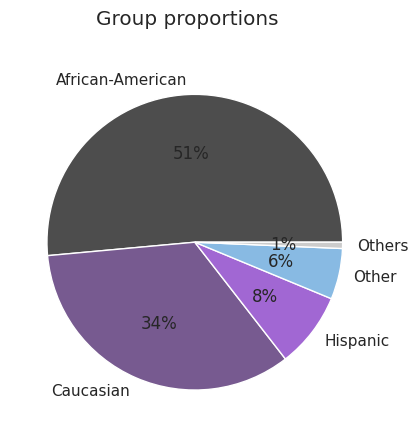

In [7]:
group_pie_plot(input['race'])

<Axes: >

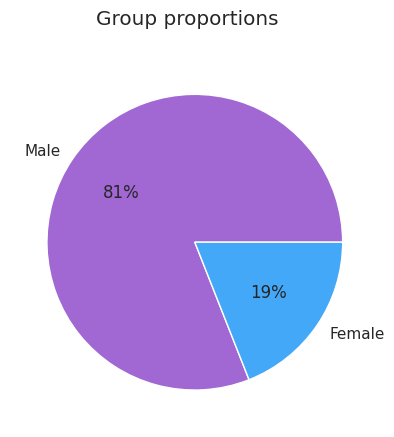

In [8]:
group_pie_plot(input['sex'])

<Axes: title={'center': 'Frequency matrix plot'}, xlabel='Class', ylabel='Group'>

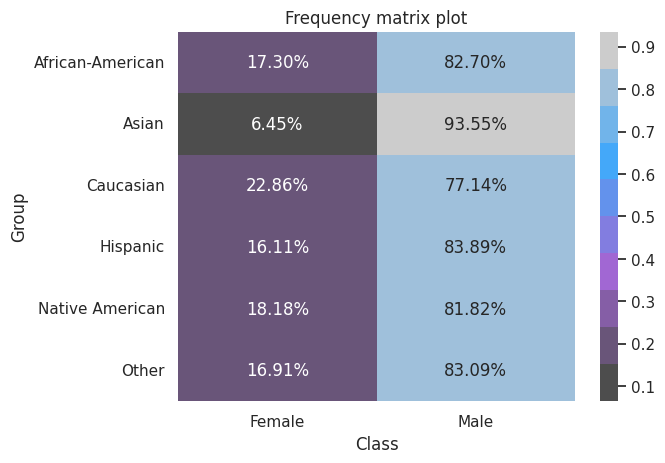

In [13]:
frequency_matrix_plot(input['race'], input['sex'], normalize='group')

## Procesado de datos

In [ ]:
#Codificamos los atributos protegidos

input.index = pd.MultiIndex.from_arrays(input.index.codes, names=input.index.names)
output.index = pd.MultiIndex.from_arrays(output.index.codes, names=output.index.names)

#Codificamos los valores de las columnas categoricas tanto en el input como en el output

le = LabelEncoder()
le2 = LabelEncoder()

for columna in input.columns:
  if input[columna].dtype != 'int64':
    input[columna] = le.fit_transform(input[columna])

output = pd.Series(le2.fit_transform(output), index=output.index)

#Dividimos los datos en conjuntos de entrenamiento y test
x_train, x_test, y_train, y_test = train_test_split(input, output, test_size=0.2, random_state=42)

## Experimento 1 (asumimos que todas las clases son igual de importantes)



In [ ]:
modelo = RandomForestClassifier(random_state=42)
modelo.fit(x_train, y_train)
y_pred = modelo.predict(x_test)

precision1 = accuracy_score(y_test, y_pred) * 100

spd1_sexo = statistical_parity_difference(y_test, y_pred, prot_attr='sex')
spd1_raza = statistical_parity_difference(y_test, y_pred, prot_attr='race')

dpr1_sexo = disparate_impact_ratio(y_test, y_pred, prot_attr='sex')
dpr1_raza = disparate_impact_ratio(y_test, y_pred, prot_attr='race')

print("Precision del modelo: {:.2f}%".format(precision1))

print("Statistical Parity Difference sexo: {:.5f}".format(spd1_sexo))
print("Statistical Parity Difference raza: {:.5f}".format(spd1_raza))

print("Disparate Impact Ratio sexo: {:.5f}".format(dpr1_sexo))
print("Disparate Impact Ratio raza: {:.5f}".format(dpr1_raza))

Precision del modelo: 64.10%
Statistical Parity Difference sexo: -0.12063
Statistical Parity Difference raza: -0.19472
Disparate Impact Ratio sexo: 0.81523
Disparate Impact Ratio raza: 0.74038


## Experimento 2 (reasignamos pesos con *sklearn*)



In [ ]:
class_weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(y_train), y = y_train)
pesos_pixeles = np.zeros(y_train.shape)
for i, tag in enumerate(y_train):
  if tag==0:
    pesos_pixeles[i] = class_weights[0]
  else:
    pesos_pixeles[i] = class_weights[1]

In [ ]:
model2 = RandomForestClassifier()
model2.fit(x_train, y_train, sample_weight=pesos_pixeles)

y_pred = model2.predict(x_test)

precision2 = accuracy_score(y_pred, y_test)*100

spd2_sexo = statistical_parity_difference(y_test, y_pred, prot_attr='sex')
spd2_raza = statistical_parity_difference(y_test, y_pred, prot_attr='race')

dpr2_sexo = disparate_impact_ratio(y_test, y_pred, prot_attr='sex')
dpr2_raza = disparate_impact_ratio(y_test, y_pred, prot_attr='race')

print("Model accuracy: {:.2f} %".format(precision2))

print("Statistical Parity Difference contando el sexo: {:.5f}".format(spd2_sexo))
print("Statistical Parity Difference contando la raza: {:.5f}".format(spd2_raza))

print("Disparate Impact Ratio contando el sexo: {:.5f}".format(dpr2_sexo))
print("Disparate Impact Ratio contando la raza: {:.5f}".format(dpr2_raza))

Model accuracy: 63.61 %
Statistical Parity Difference contando el sexo: -0.11862
Statistical Parity Difference contando la raza: 0.05772
Disparate Impact Ratio contando el sexo: 0.81832
Disparate Impact Ratio contando la raza: 1.11545


## Experimento 3 (reasignamos pesos mediante preprocesamiento con *Reweighing*)



In [ ]:
rew = ReweighingMeta(estimator=RandomForestClassifier(),
                     reweigher=Reweighing())

params = {'estimator__n_estimators': [100, 300, 500, 700]}

model3 = GridSearchCV(estimator=rew, param_grid=params, scoring='accuracy')
model3.fit(x_train, y_train)

y_pred = model3.predict(x_test)

precision3 = accuracy_score(y_pred, y_test)*100

spd3_sexo = statistical_parity_difference(y_test, y_pred, prot_attr='sex')
spd3_raza = statistical_parity_difference(y_test, y_pred, prot_attr='race')

dpr3_sexo = disparate_impact_ratio(y_test, y_pred, prot_attr='sex')
dpr3_raza = disparate_impact_ratio(y_test, y_pred, prot_attr='race')

print("Model accuracy: {:.2f} %".format(precision3))
print("Statistical Parity Difference contando el sexo: {:.5f}".format(spd3_sexo))
print("Statistical Parity Difference contando la raza: {:.5f}".format(spd3_raza))

print("Disparate Impact Ratio contando el sexo: {:.5f}".format(dpr3_sexo))
print("Disparate Impact Ratio contando la raza: {:.5f}".format(dpr3_raza))

Model accuracy: 64.26 %
Statistical Parity Difference contando el sexo: -0.10118
Statistical Parity Difference contando la raza: -0.19146
Disparate Impact Ratio contando el sexo: 0.84203
Disparate Impact Ratio contando la raza: 0.74472


In [ ]:
resultados_metricas = pd.DataFrame()

resultados_metricas['Experimento 1'] = [precision1, spd1_sexo, spd1_raza, dpr1_sexo, dpr1_raza]
resultados_metricas['Experimento 2'] = [precision2, spd2_sexo, spd2_raza, dpr2_sexo, dpr2_raza]
resultados_metricas['Experimento 3'] = [precision3, spd3_sexo, spd3_raza, dpr3_sexo, dpr3_raza]

resultados_metricas.set_index(pd.Series(['Precision modelo (en %)',
                                         'Statistical Parity Difference sexo',
                                         'Statistical Parity Difference raza',
                                         'Disparate Impact Ratio sexo',
                                         'Disparate Impact Ratio raza']), inplace=True)
resultados_metricas

,Experimento 1,Experimento 2,Experimento 3
Precision modelo (en %),64.100486,63.614263,64.262561
Statistical Parity Difference sexo,-0.120634,-0.118618,-0.101181
Statistical Parity Difference raza,-0.194715,0.057724,-0.191463
Disparate Impact Ratio sexo,0.815231,0.818319,0.842027
Disparate Impact Ratio raza,0.740379,1.115447,0.744715
